c:\Second_Sem\490\env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Second_Sem\490\env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Train Loss: 0.6681, Train Accuracy: 75.03%
Epoch 1, Val Loss: 0.5293, Val Accuracy: 81.79%
Epoch 2, Train Loss: 0.4599, Train Accuracy: 82.60%
Epoch 2, Val Loss: 0.5125, Val Accuracy: 81.60%
Epoch 3, Train Loss: 0.3857, Train Accuracy: 85.91%
Epoch 3, Val Loss: 0.5251, Val Accuracy: 81.06%
Epoch 4, Train Loss: 0.3564, Train Accuracy: 87.28%
Epoch 4, Val Loss: 0.5569, Val Accuracy: 79.78%
Epoch 5, Train Loss: 0.2944, Train Accuracy: 89.78%
Epoch 5, Val Loss: 0.6441, Val Accuracy: 81.06%
Epoch 6, Train Loss: 0.2123, Train Accuracy: 93.17%
Epoch 6, Val Loss: 0.6222, Val Accuracy: 80.15%
Epoch 7, Train Loss: 0.1640, Train Accuracy: 94.34%
Epoch 7, Val Loss: 0.5661, Val Accuracy: 83.42%
Epoch 8, Train Loss: 0.1258, Train Accuracy: 95.83%
Epoch 8, Val Loss: 0.5778, Val Accuracy: 81.97%
Epoch 9, Train Loss: 0.0867, Train Accuracy: 97.42%
Epoch 9, Val Loss: 0.6020, Val Accuracy: 82.88%
Epoch 10, Train Loss: 0.0747, Train Accuracy: 97.66%
Epoch 10, Val Loss: 0.6274, Val Accuracy: 81.60

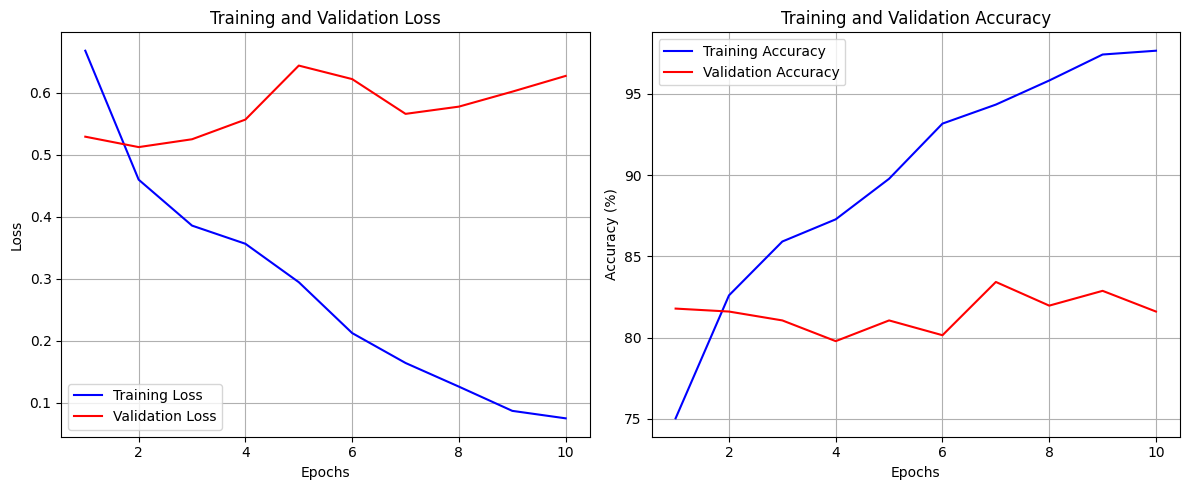

Test Accuracy: 82.18%
Model training complete with test accuracy: 82.18%
Model saved as 'retinal_cnn_model.pth'
Training metrics visualization saved as 'training_metrics.png'


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from PIL import Image
import pandas as pd
import os
import matplotlib.pyplot as plt

class RetinalDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            img_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data_frame = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform if transform is not None else transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.data_frame.iloc[idx]['id_code'] + '.png')
        image = Image.open(img_name).convert('RGB')
        diagnosis = self.data_frame.iloc[idx]['diagnosis']
        
        if self.transform:
            image = self.transform(image)
            
        return image, torch.tensor(diagnosis, dtype=torch.long)

class RetinalCNNClassifier:
    def __init__(self, num_classes=5):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Use ResNet50 as the CNN backbone
        self.model = models.resnet50(pretrained=True)
        
        # Replace the final fully connected layer to match our number of classes
        num_features = self.model.fc.in_features
        self.model.fc = nn.Linear(num_features, num_classes)
        
        # Move model to device
        self.model = self.model.to(self.device)
        
        # Define transformation pipeline
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
        ])
        
        # Metrics tracking
        self.train_losses = []
        self.train_accuracies = []
        self.val_losses = []
        self.val_accuracies = []

    def train(self, train_loader, val_loader=None, num_epochs=10, learning_rate=0.0001):
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
        
        for epoch in range(num_epochs):
            # Training phase
            self.model.train()
            running_loss = 0.0
            correct = 0
            total = 0
            
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                
                # Calculate accuracy
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            
            epoch_loss = running_loss/len(train_loader)
            epoch_accuracy = 100 * correct / total
            
            # Store training metrics
            self.train_losses.append(epoch_loss)
            self.train_accuracies.append(epoch_accuracy)
            
            print(f'Epoch {epoch+1}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.2f}%')
            
            # Validation phase (if validation loader provided)
            if val_loader:
                val_loss, val_accuracy = self.validate(val_loader, criterion)
                self.val_losses.append(val_loss)
                self.val_accuracies.append(val_accuracy)
                print(f'Epoch {epoch+1}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')
                
                # Update learning rate based on validation loss
                scheduler.step(val_loss)
            else:
                # Update learning rate based on training loss
                scheduler.step(epoch_loss)
    
    def validate(self, val_loader, criterion):
        """Evaluate model on validation set"""
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss = running_loss / len(val_loader)
        val_accuracy = 100 * correct / total
        
        return val_loss, val_accuracy
    
    def evaluate(self, test_loader):
        self.model.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
        accuracy = 100 * correct / total
        print(f'Test Accuracy: {accuracy:.2f}%')
        return accuracy

    def predict(self, image_path):
        self.model.eval()
        image = Image.open(image_path).convert('RGB')
        image = self.transform(image).unsqueeze(0).to(self.device)
        
        with torch.no_grad():
            outputs = self.model(image)
            _, predicted = torch.max(outputs, 1)
            
        return predicted.item()
    
    def plot_metrics(self):
        """Plot training (and validation) metrics"""
        plt.figure(figsize=(12, 5))
        
        # Plot loss
        plt.subplot(1, 2, 1)
        epochs = range(1, len(self.train_losses) + 1)
        plt.plot(epochs, self.train_losses, 'b-', label='Training Loss')
        if self.val_losses:
            plt.plot(epochs, self.val_losses, 'r-', label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        
        # Plot accuracy
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.train_accuracies, 'b-', label='Training Accuracy')
        if self.val_accuracies:
            plt.plot(epochs, self.val_accuracies, 'r-', label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy (%)')
        plt.legend()
        plt.grid(True)
        
        plt.tight_layout()
        plt.savefig('training_metrics.png')
        plt.show()

# Usage example
if __name__ == "__main__":
    # Initialize dataset with transformations
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Load dataset
    dataset = RetinalDataset(
        csv_file='train.csv', 
        img_dir='train_images',
        transform=transform
    )

    # Split dataset (70% train, 15% validation, 15% test)
    train_size = int(0.7 * len(dataset))
    val_size = int(0.15 * len(dataset))
    test_size = len(dataset) - train_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Initialize and train the classifier
    classifier = RetinalCNNClassifier(num_classes=5)
    
    # Train the model
    classifier.train(train_loader, val_loader, num_epochs=10)
    
    # Plot training metrics
    classifier.plot_metrics()
    
    # Evaluate on test set
    test_accuracy = classifier.evaluate(test_loader)
    
    # Save the trained model
    torch.save(classifier.model.state_dict(), 'retinal_cnn_model.pth')
    
    print(f"Model training complete with test accuracy: {test_accuracy:.2f}%")
    print("Model saved as 'retinal_cnn_model.pth'")
    print("Training metrics visualization saved as 'training_metrics.png'")